## Import Library + Download MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.ndimage import convolve, gaussian_filter
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import matplotlib.pyplot as plt
import cv2

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


## Visualize some training samples

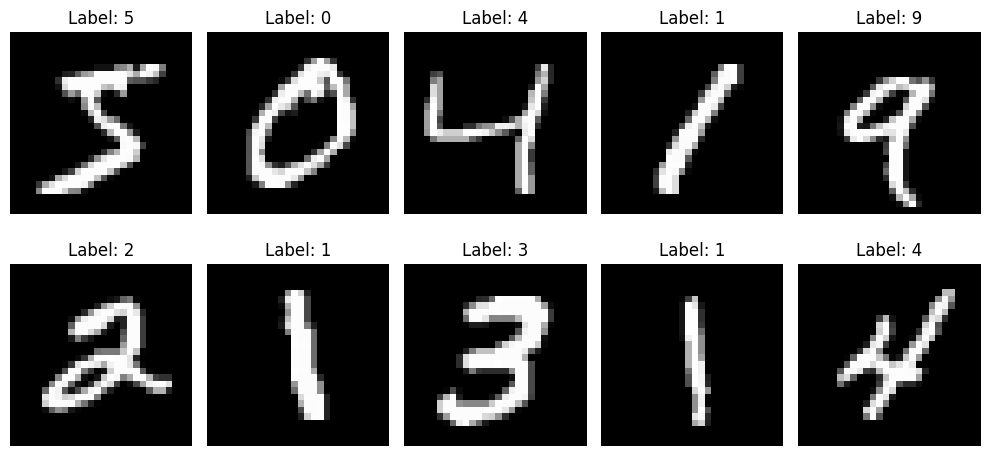

In [2]:
def visualize_image(image,label = None):
    plt.figure(figsize=(10, 5))
    # for i in range(num_images):
        # plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')
    if label is not None:
      plt.title(f'Label: {label}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the first 10 images and their labels
visualize_images(train_images, train_labels, num_images=10)

## Gabor Filter: create a set of kernels, then apply the convolution to the input image

In [3]:
import random
random.seed(42)
np.random.seed(42)
def create_uniform_gabor_kernels(ksize=3, theta_steps=5, sigma_steps=3):
    theta_values = np.linspace(0, np.pi, theta_steps)
    sigma_values = np.linspace(1.0, 10, sigma_steps)

    gabor_kernels = []

    for theta in theta_values:
        for sigma in sigma_values:
            lambd = 10.0 / sigma  # Adjust lambda based on sigma for better visualization
            gamma = 0.5  # Fixed gamma value
            psi = np.pi / 2  # Fixed psi value

            gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
            gabor_kernels.append(gabor_kernel)

    return gabor_kernels

def apply_gabor_filters(patch, kernels):
    filtered_patches = []
    for kernel in kernels:
    # gabor_kernel = create_random_gabor_kernel(ksize=3)
      filtered_patch = cv2.filter2D(patch, cv2.CV_32F, kernel)
      filtered_patches.append(filtered_patch)
    return np.stack(filtered_patches, axis=-1)  # Stack along the last dimension to form a 4x4xN matrix

def divide_into_patches(image, patch_size=4):
    patches = []
    num_patches_x = image.shape[1] // patch_size
    num_patches_y = image.shape[0] // patch_size
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            patches.append(patch)
    return patches

def extract_gabor_features(image_batch,kernels, N=5, patch_size=4):
    all_gabor_features = []
    for image in image_batch:
        patches = divide_into_patches(image, patch_size)
        gabor_features = []
        for patch in patches:
            gabor_filtered_patch = apply_gabor_filters(patch, kernels)
            gabor_features.append(gabor_filtered_patch.flatten())  # Flatten the 4x4xN matrix into a vector

        all_gabor_features.append(np.concatenate(gabor_features))  # Concatenate all patch vectors into a single feature vector

    return np.array(all_gabor_features)  # Convert to a NumPy array for batch processing


def extract_gabor_features(image_batch, kernels, N=5, patch_size=4):
    all_gabor_features = []
    for image in image_batch:
        # patches = divide_into_patches(image, patch_size)
        gabor_features = apply_gabor_filters(image, kernels)
        all_gabor_features.append(gabor_features.flatten())

    return np.array(all_gabor_features)  # Convert to a NumPy array for batch processing

## Sample a small train/test subset to save time

In [4]:
num_train_samples = 5000
num_test_samples = 2000
train_images, train_labels = train_images[:num_train_samples], train_labels[:num_train_samples]
test_images, test_labels = test_images[:num_test_samples], test_labels[:num_test_samples]

## Create a set of kernels

In [5]:
kernels = create_uniform_gabor_kernels(ksize=3, theta_steps=5, sigma_steps=3)

## Extract image features

In [6]:
train_features = extract_gabor_features(train_images, kernels)
train_features.shape

(5000, 11760)

In [7]:
test_features = extract_gabor_features(test_images, kernels)
print("Feature vector shape:", test_features.shape)

Feature vector shape: (2000, 11760)


## Train SVM classification model

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_features)

# Transform training and test data
scaled_train_features = scaler.transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [10]:
svm_model = SVC(kernel='linear')

svm_model.fit(scaled_train_features, train_labels)

SVC(kernel='linear')

In [11]:
predictions = svm_model.predict(scaled_test_features)

In [12]:
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a detailed classification report
print(classification_report(test_labels, predictions))

Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       175
           1       0.92      0.99      0.95       234
           2       0.85      0.85      0.85       219
           3       0.83      0.86      0.84       207
           4       0.85      0.91      0.88       217
           5       0.82      0.86      0.84       179
           6       0.91      0.88      0.89       178
           7       0.84      0.81      0.83       205
           8       0.89      0.70      0.78       192
           9       0.82      0.82      0.82       194

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



# Visualize Some Gabor Filters


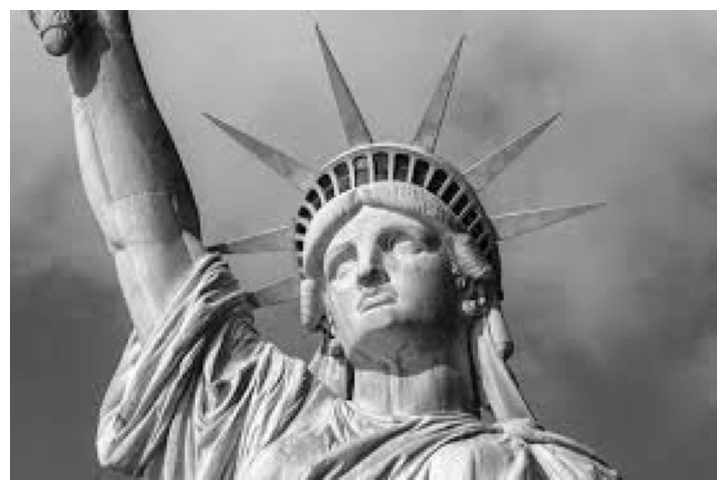

In [14]:
# Read the image from file
image_path = 'statue_of_iberty.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
visualize_image(image)

In [15]:
def visualize_images(original_image, filtered_image, gabor_kernel):
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Gabor kernel
    plt.subplot(1, 3, 2)
    plt.imshow(gabor_kernel, cmap='gray')
    plt.title('Gabor Kernel')
    plt.axis('off')
    plt.colorbar()

    # Filtered image
    plt.subplot(1, 3, 3)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


## Same orientation, different frequencies (theta)

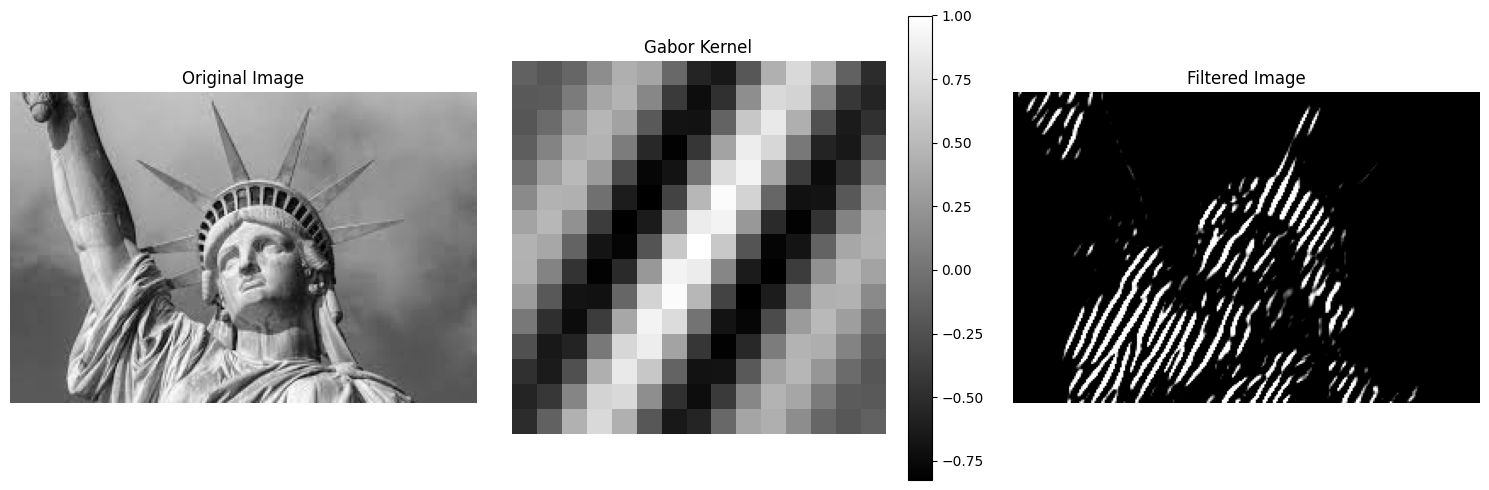

In [16]:
ksize = 15  # Size of the kernel
sigma = 5.0  # Standard deviation of the Gaussian function
theta = np.pi / 6  # Orientation of the sinusoidal wave (45 degrees)
lambd = 6  # Wavelength of the sinusoidal wave
gamma = 0.5  # Spatial aspect ratio
psi = 0  # Phase offset


def apply_gabor_filter(image, ksize=21, sigma=5.0, theta=np.pi/4, lambd=10.0, gamma=0.5, psi=0):
    # Create Gabor kernel
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    # Apply Gabor filter
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)
    return filtered_image, gabor_kernel
# Create the Gabor kernel
filtered_image, gabor_kernel = apply_gabor_filter(image, ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)

# Create the Gabor kernel
filtered_image, gabor_kernel = apply_gabor_filter(image, ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)

# Visualize the original and filtered images
visualize_images(image, filtered_image, gabor_kernel)

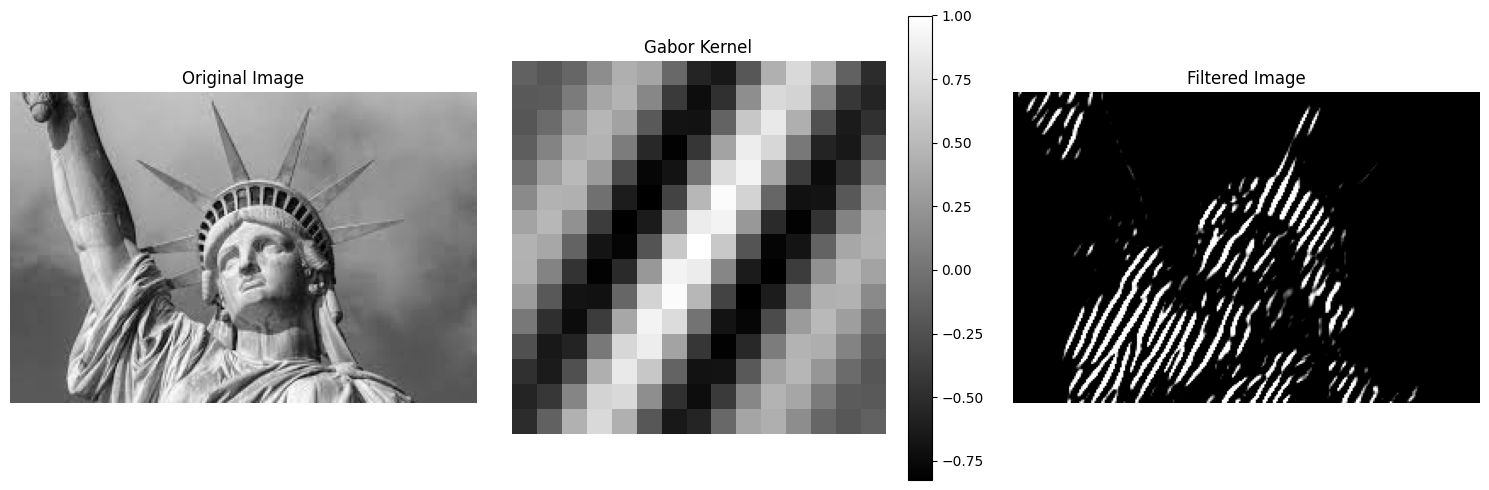

In [17]:
# Parameters for the Gabor kernel
ksize = 15  # Size of the kernel
sigma = 5.0  # Standard deviation of the Gaussian function
theta = np.pi / 6  # Orientation of the sinusoidal wave (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal wave
gamma = 0.5  # Spatial aspect ratio
psi = 0  # Phase offset


# Function to visualize original and filtered images
def visualize_images(original_image, filtered_image, gabor_kernel):
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Gabor kernel
    plt.subplot(1, 3, 2)
    plt.imshow(gabor_kernel, cmap='gray')
    plt.title('Gabor Kernel')
    plt.axis('off')
    plt.colorbar()

    # Filtered image
    plt.subplot(1, 3, 3)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the original and filtered images
visualize_images(image, filtered_image, gabor_kernel)

## Same frequency, different orientation

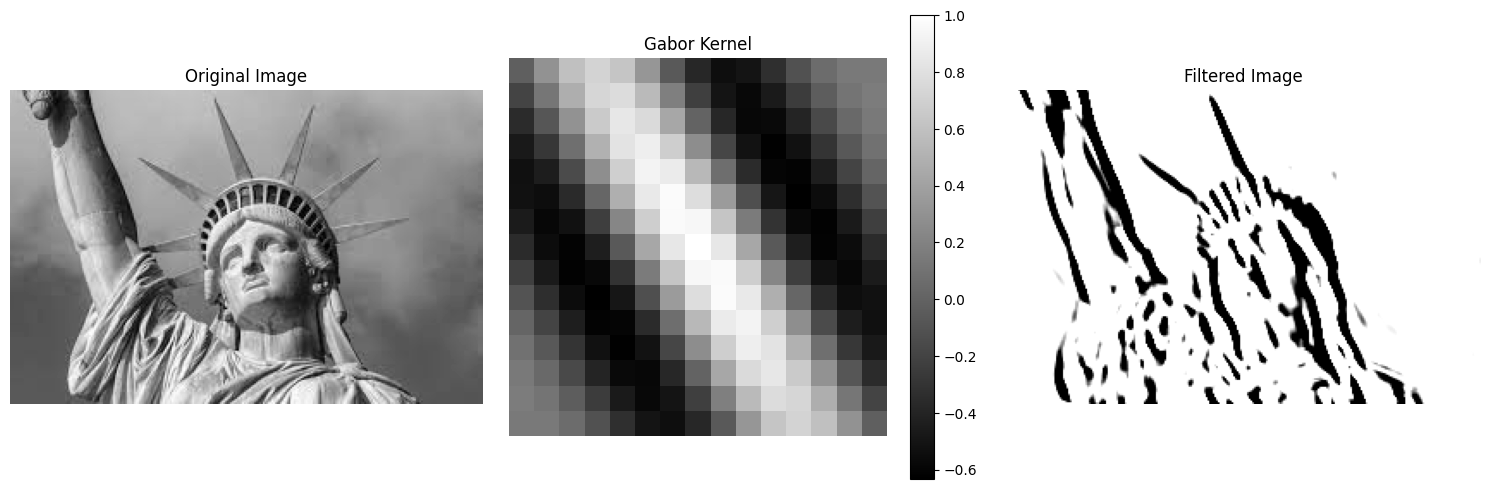

In [18]:
# Parameters for the Gabor kernel
ksize = 15  # Size of the kernel
sigma = 5.0  # Standard deviation of the Gaussian function
theta = - np.pi / 6  # Orientation of the sinusoidal wave (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal wave
gamma = 0.5  # Spatial aspect ratio
psi = 0  # Phase offset

# Create the Gabor kernel
filtered_image, gabor_kernel = apply_gabor_filter(image, ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)



# Visualize the original and filtered images
visualize_images(image, filtered_image, gabor_kernel)

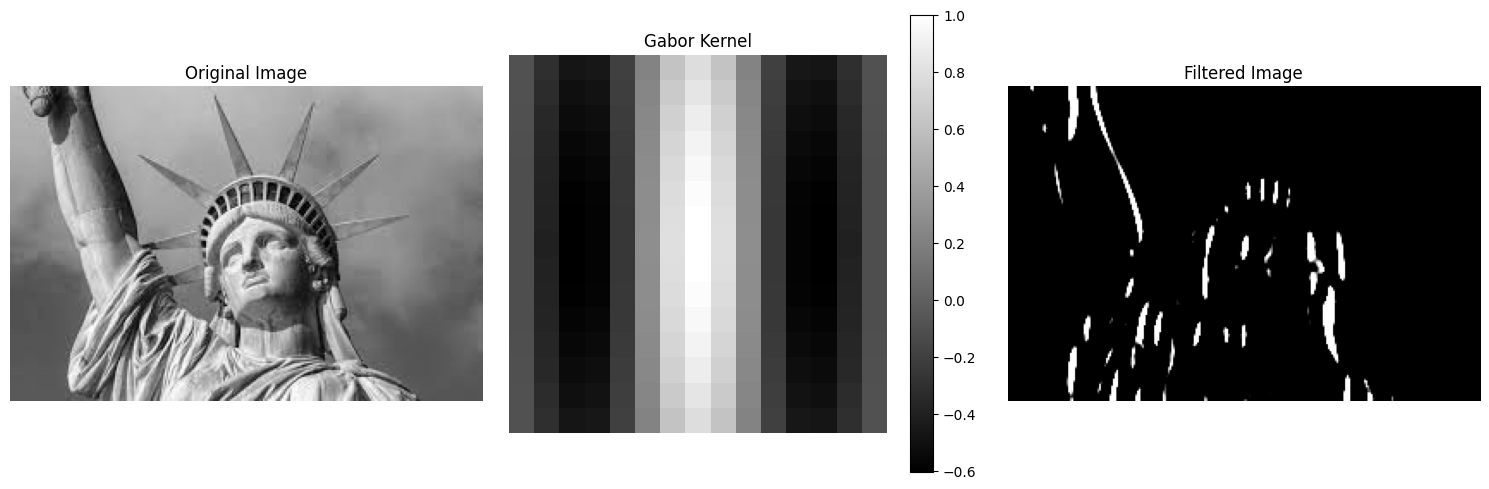

In [19]:
# Parameters for the Gabor kernel
ksize = 15  # Size of the kernel
sigma = 5.0  # Standard deviation of the Gaussian function
theta = np.pi   # Orientation of the sinusoidal wave (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal wave
gamma = 0.5  # Spatial aspect ratio
psi = 0  # Phase offset

# Create the Gabor kernel
filtered_image, gabor_kernel = apply_gabor_filter(image, ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)



# Visualize the original and filtered images
visualize_images(image, filtered_image, gabor_kernel)

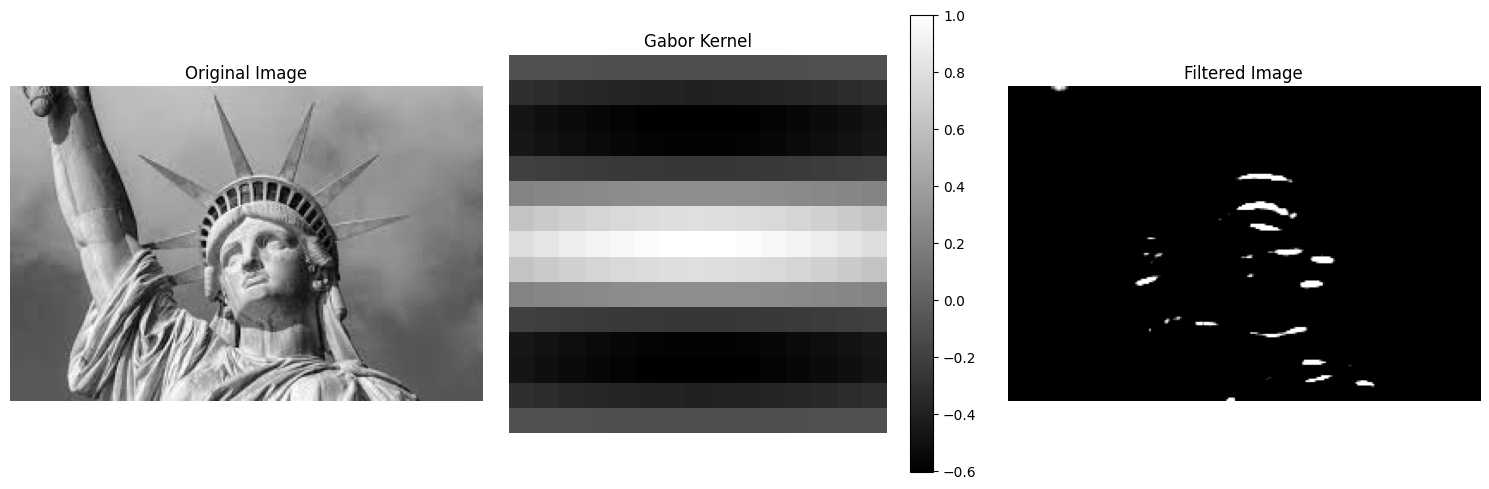

In [20]:
# Parameters for the Gabor kernel
ksize = 15  # Size of the kernel
sigma = 5.0  # Standard deviation of the Gaussian function
theta = np.pi / 2 # Orientation of the sinusoidal wave (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal wave
gamma = 0.5  # Spatial aspect ratio
psi = 0  # Phase offset

filtered_image, gabor_kernel = apply_gabor_filter(image, ksize=ksize, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)

# Visualize the original and filtered images
visualize_images(image, filtered_image, gabor_kernel)